In [28]:
import os
import re
import sys
import tarfile
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


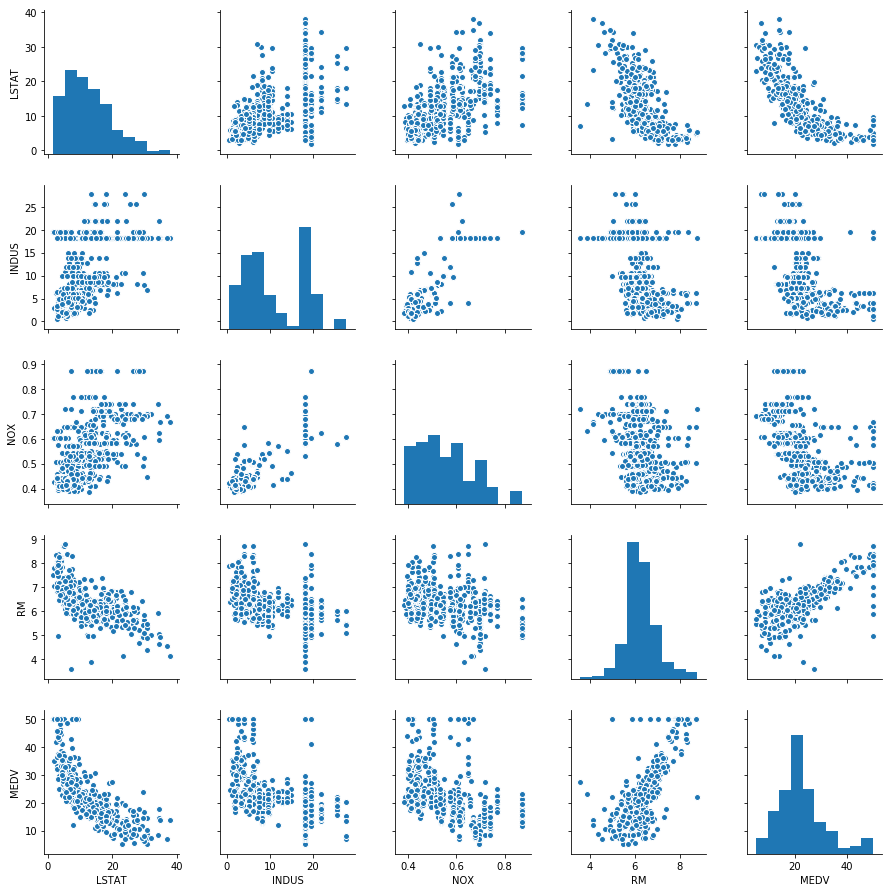

In [30]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('images/10_03.png', dpi=300)
plt.show()

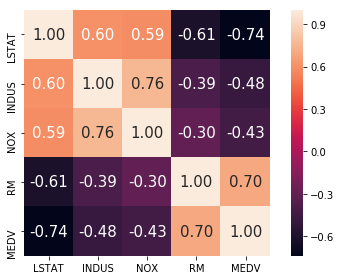

In [31]:
cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
# plt.savefig('images/10_04.png', dpi=300)
plt.show()

### 線形回帰モデル

In [32]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [33]:
X = df[['RM']].values
y = df['MEDV'].values

In [34]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() # np.newaxis：次元追加

In [35]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

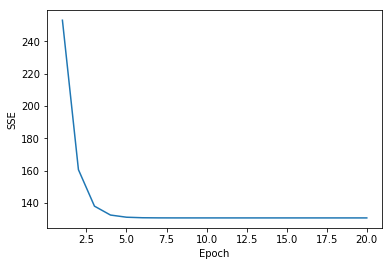

In [36]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
#plt.tight_layout()
#plt.savefig('images/10_05.png', dpi=300)
plt.show()

In [37]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

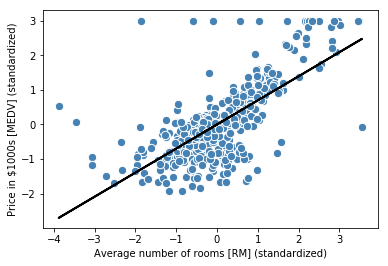

In [38]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

#plt.savefig('images/10_06.png', dpi=300)
plt.show()

In [39]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


In [40]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


### RANSACを使ったロバスト回帰モデル

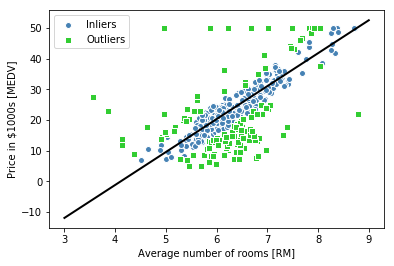

In [43]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_ # True/Falseで正常値/外れ値を返却
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')

plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')

plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

#plt.savefig('images/10_08.png', dpi=300)
plt.show()

In [44]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


### 線形回帰モデルの性能評価

In [50]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

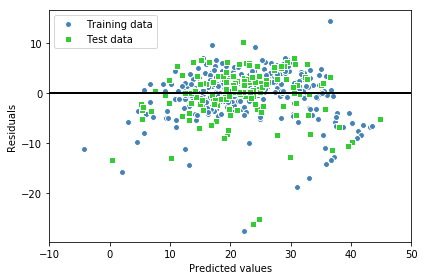

In [51]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


### 線形回帰モデルの正則化手法

In [56]:
from sklearn.linear_model import Ridge

# リッジ回帰(L2正則化)
ridge = Ridge(alpha=1.0) # ペナルティ項の影響度を表すパラメータ
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print(ridge.coef_)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[-1.18308575e-01  4.61259764e-02 -2.08626416e-02  2.45868617e+00
 -8.25958494e+00  3.89748516e+00 -1.79140171e-02 -1.39737175e+00
  2.18432298e-01 -1.16338128e-02 -9.31711410e-01  7.26996266e-03
 -4.94046539e-01]
MSE train: 20.145, test: 27.762
R^2 train: 0.762, test: 0.667


In [55]:
from sklearn.linear_model import Lasso

# LASSO回帰(L1正則化)
lasso = Lasso(alpha=0.1) # ペナルティ項の影響度を表すパラメータ
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(lasso.coef_)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]
MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


In [57]:
from sklearn.linear_model import ElasticNet

# Elastic Net(L1 + L2正則化)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)
elanet.fit(X_train, y_train)
y_train_pred = elanet.predict(X_train)
y_test_pred = elanet.predict(X_test)

print(lasso.coef_)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]
MSE train: 24.381, test: 31.874
R^2 train: 0.712, test: 0.617


### 多項式の項の追加

In [68]:
# 学習
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

# 予測
X_fit = np.arange(250, 600, 10)[:, np.newaxis] # 250から10刻みに600コ

In [69]:
### 通常の線形回帰モデル
# 学習
lr = LinearRegression()
lr.fit(X, y)

# 予測
y_lin_fit = lr.predict(X_fit)

In [70]:
### 多項式項を追加した線形回帰モデル
from sklearn.preprocessing import PolynomialFeatures

# 学習
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X) # 多項式に適合するようデータを変換
pr.fit(X_quad, y)

# 予測
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

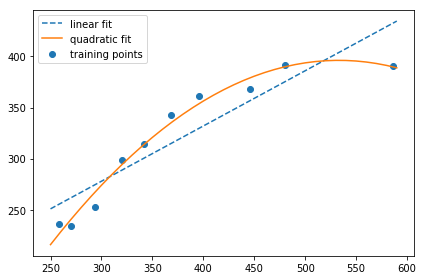

In [71]:
# 結果をプロット
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/10_10.png', dpi=300)
plt.show()

In [75]:
# 学習に使ったデータで予測
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

# 評価値を出力
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### 非線形モデル(2次・3次)

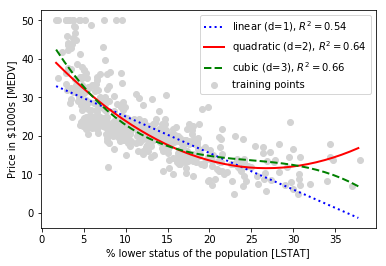

In [78]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# モデル
regr = LinearRegression()
# 予測用のデータ
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis] # 最小値と最小値の間で1ずつ増加

### 線形回帰
# 学習
regr = regr.fit(X, y)
# 予測
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

### 2次
# 学習
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
regr = regr.fit(X_quad, y)
# 予測
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

### 3次
# 学習
cubic = PolynomialFeatures(degree=3)
X_cubic = cubic.fit_transform(X)
regr = regr.fit(X_cubic, y)
# 予測
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# 結果をプロット
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

#plt.savefig('images/10_11.png', dpi=300)
plt.show()

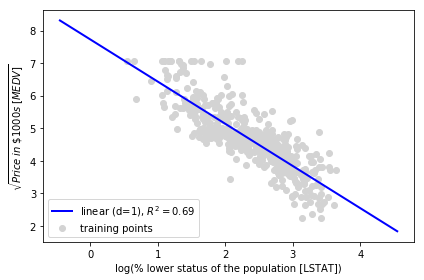

In [79]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# 特徴量を変換
X_log = np.log(X)    # 変数の対数
y_sqrt = np.sqrt(y)  # 平方根

# 予測に使うデータ
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

# 線形回帰モデルへの学習と予測
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# 結果をプロット
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('images/10_12.png', dpi=300)
plt.show()

### ランダムフォレストを用いた非線形への対処

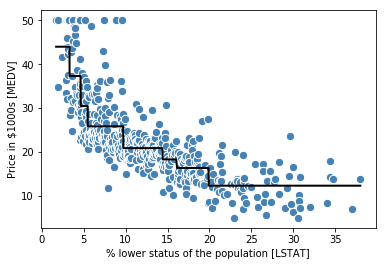

In [80]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort() #並び替えたインデックスの値(昇順)

lin_regplot(X[sort_idx], y[sort_idx], tree) # 10.3.1項で定義

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
#plt.savefig('images/10_13.png', dpi=300)
plt.show()

### ランダムフォレスト回帰

In [83]:
# データセットの用意
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [84]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, # 決定木の数
                               criterion='mse',   # 決定木の成長条件となる指標 
                               random_state=1,
                               n_jobs=-1)         # 並行処理の数

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


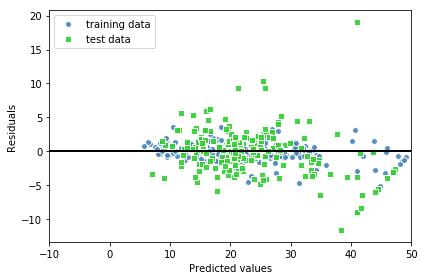

In [85]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')

plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()